# DeepFake Audio Detection - Production Ready Code
## Dataset: Kaggle Fake-or-Real (FoR) (2-seconds version)
## Architecture: 2D Convolutional Neural Network (CNN) on Mel-Spectrograms

In [4]:
# --- STAGE 1: IMPORTS & CONFIGURATION ---
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration Parameters
CONF = {
    'SAMPLE_RATE': 16000,    # 16kHz is standard for speech
    'DURATION': 2,
    'N_MELS': 128,
    'HOP_LENGTH': 512,
    'BATCH_SIZE': 32,
    'EPOCHS': 20,
    'DATA_PATH': '/content/drive/MyDrive/Datasets/for-2seconds',
    'IMG_SIZE': (128, 64, 1) # Target shape (Freq, Time, Channels)
}


In [5]:
# --- STAGE 2: DATA PREPROCESSING & LOADING ---

def extract_features(file_path):
    """
    Loads audio and converts to Mel-Spectrogram image.
    Returns: Normalized numpy array of shape (128, 64, 1)
    """
    try:
        # 1. Load Audio
        y, sr = librosa.load(file_path, sr=CONF['SAMPLE_RATE'], duration=CONF['DURATION'])

        # 2. Padding/Truncating (Ensure exactly 2 seconds)
        expected_length = int(CONF['SAMPLE_RATE'] * CONF['DURATION'])
        if len(y) < expected_length:
            y = np.pad(y, (0, expected_length - len(y)))
        else:
            y = y[:expected_length]

        # 3. Compute Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=CONF['N_MELS'], hop_length=CONF['HOP_LENGTH']
        )

        # 4. Convert to Log-Scale (dB)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # 5. Add Channel Dimension (Height, Width, 1) -> Like a Greyscale Image
        data = mel_spec_db[..., np.newaxis]

        # Resize to fixed dimension to be safe (128 freq bins, 64 time frames)
        data = tf.image.resize(data, (CONF['IMG_SIZE'][0], CONF['IMG_SIZE'][1])).numpy()

        return data

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset(base_path):
    """
    Scans directories for 'real' and 'fake' folders.
    Returns: X (features), y (labels)
    """
    X = []
    y = []

    # Check paths - Assumes structure: base_path/training/real etc.
    # We will look for any folder named 'real' or 'fake' recursively or explicitly
    classes = {'real': 0, 'fake': 1} # 0=Real, 1=Fake

    print("Scanning dataset... This may take time.")

    # Walk through directory
    for root, dirs, files in os.walk(base_path):
        for class_name, label in classes.items():
            if class_name in os.path.basename(root).lower():
                print(f"Processing folder: {root}")
                # Limit for demonstration if dataset is massive (e.g., take first 2000 each)
                for file in tqdm(files[:2000]):
                    if file.endswith('.wav') or file.endswith('.mp3'):
                        file_path = os.path.join(root, file)
                        feature = extract_features(file_path)
                        if feature is not None:
                            X.append(feature)
                            y.append(label)

    return np.array(X), np.array(y)

# Load Data
# Note: In a real large-scale scenario, use tf.data.Dataset generators instead of loading to RAM.
X, y = load_dataset(CONF['DATA_PATH'])

print(f"Data Loaded: {X.shape}, Labels: {y.shape}")

# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Scanning dataset... This may take time.
Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/validation/real


100%|██████████| 1413/1413 [01:01<00:00, 22.99it/s]


Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/validation/fake


100%|██████████| 1413/1413 [00:52<00:00, 26.87it/s]


Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/testing/real


100%|██████████| 544/544 [00:17<00:00, 31.97it/s]


Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/testing/fake


100%|██████████| 544/544 [00:17<00:00, 30.89it/s] 


Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/training/real


100%|██████████| 2000/2000 [02:19<00:00, 14.34it/s]


Processing folder: /content/drive/MyDrive/Datasets/for-2seconds/training/fake


100%|██████████| 2000/2000 [02:25<00:00, 13.79it/s]


Data Loaded: (7914, 128, 64, 1), Labels: (7914,)


In [6]:
# --- STAGE 3: MODEL ARCHITECTURE (Custom 2D CNN) ---

def build_deepfake_detector(input_shape):
    model = models.Sequential([
        # Input Layer
        layers.Input(shape=input_shape),

        # Convolutional Block 1 (Capture low-level features)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Convolutional Block 2 (Capture mid-level features)
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Convolutional Block 3 (Capture high-level features)
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_deepfake_detector(CONF['IMG_SIZE'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,465 (8.36 MB)

 Trainable params: 2,190,273 (8.36 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
# --- STAGE 4: TRAINING ---

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

print("Starting Training...")
history = model.fit(
    X_train, y_train,
    epochs=CONF['EPOCHS'],
    batch_size=CONF['BATCH_SIZE'],
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Starting Training...
Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6707 - loss: 1.1123 - val_accuracy: 0.9375 - val_loss: 0.2257 - learning_rate: 0.0010
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9425 - loss: 0.1611 - val_accuracy: 0.7934 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9650 - loss: 0.1101 - val_accuracy: 0.8869 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9895 - loss: 0.0500 - val_accuracy: 0.9943 - val_loss: 0.0315 - learning_rate: 5.0000e-04
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9955 - loss: 0.0345 - val_accuracy: 0.9968 - val_loss: 0.0259 - learning_rate: 5.0000e-04
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9958 - loss: 0.0309 - val_accuracy: 0.9653 - val_loss: 0.1007 - learning_rate: 5.0000e-04
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/

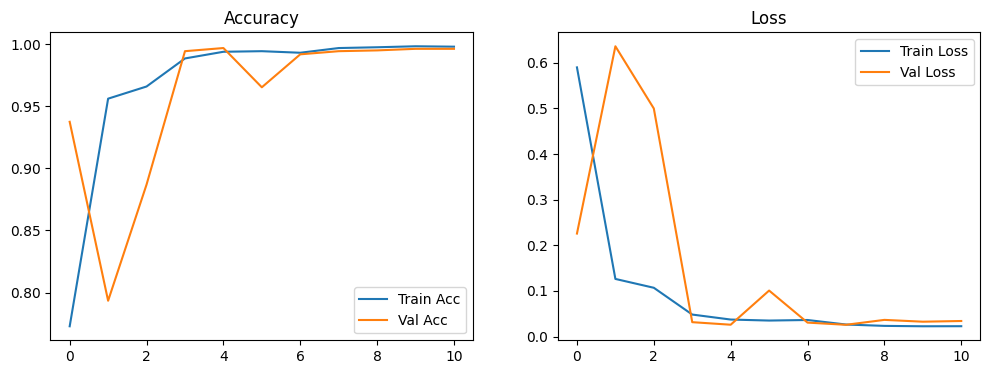

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9935 - loss: 0.0336



FINAL VALIDATION ACCURACY: 99.43%
Model saved successfully.


In [10]:
# --- STAGE 5: EVALUATION & VISUALIZATION ---

# Plotting Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Final Evaluation
loss, acc = model.evaluate(X_val, y_val)
print(f"\nFINAL VALIDATION ACCURACY: {acc*100:.2f}%")

# Example Prediction Function
def predict_audio(file_path, model):
    feature = extract_features(file_path)
    if feature is None: return "Error"
    feature = np.expand_dims(feature, axis=0) # Add batch dimension
    prediction = model.predict(feature)[0][0]

    label = "FAKE" if prediction > 0.5 else "REAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return f"{label} (Confidence: {confidence:.2f})"

# Save the model
model.save('deepfake_audio_detector_CNN.h5')
print("Model saved successfully.")

In [11]:
# Download the model
from google.colab import files
files.download('deepfake_audio_detector_CNN.h5')
print("Model DOWNLOADED successfully!!!!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model DOWNLOADED successfully!!!!
